In [1]:
import librosa
import numpy as np
import pandas as pd
import sounddevice as sd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import os
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, classification_report, f1_score

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay


# Loading Data

In [2]:
sampling_rate = 16000

def load_directory(directory):
    subdirectories = ["Hebron", "Nablus", "Jerusalem", "RamallahReef"]
    audio_list = []
    labels = []
    
    # Iterate through each subdirectory
    for subdir in subdirectories:
        # Get the full path of the subdirectory
        subdir_path = os.path.join(directory, subdir)

        # Iterate through each file in the subdirectory
        for filename in os.listdir(subdir_path):
            # Get the full path of the file
            file_path = os.path.join(subdir_path, filename)

            # Check if the path is a file
            if os.path.isfile(file_path):
                # Load the audio file
                audio, sr = librosa.load(file_path, sr=sampling_rate)
                
                # Normalize the audio to have a maximum absolute value of 1.0
                audio = librosa.util.normalize(audio)
                
                # Append audio and label
                audio_list.append(audio)
                labels.append(subdir)
    
    return audio_list, labels

In [3]:
training_directory = './training_set'
testing_directory = './testing_set'

training_voices, training_labels = load_directory(training_directory)
testing_voices, testing_labels = load_directory(testing_directory)

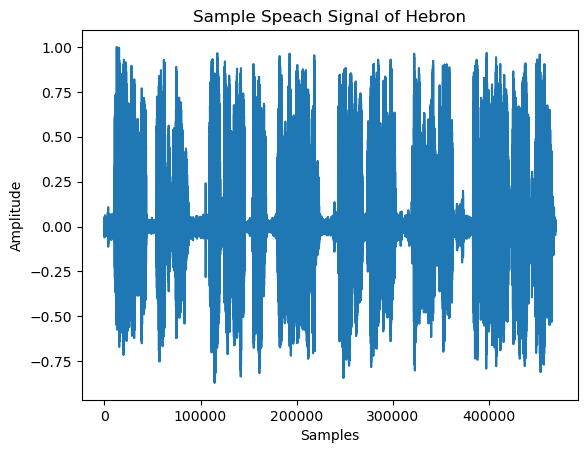

In [4]:
plt.figure()
plt.plot(training_voices[1])

plt.title(f'Sample Speach Signal of {training_labels[1]}')
plt.ylabel('Amplitude')
plt.xlabel('Samples')
plt.show()

In [5]:
def get_frame_size(sampling_rate=sampling_rate, frame_duration=20): # 20 ms default frame_duration
    return int(sampling_rate * (frame_duration / 1000))

In [6]:
def extract_features(audio, frame_size, sr=sampling_rate, n_mfcc=13):

    mfccs = librosa.feature.mfcc(
        y=audio, sr=sr, n_mfcc=n_mfcc,
        hop_length=int(frame_size // 2),
        win_length=frame_size,
        window=scipy.signal.windows.hamming
    )
#     augh = True
#     if augh:
#         print(mfccs.T.shape)
#         augh = False
    
#     # Compute statistics for each feature
#     mfccs_mean = np.mean(mfccs, axis=1)
#     mfccs_std = np.std(mfccs, axis=1)
    
    return mfccs.T


def process_voices(audio_voices, original_labels, frame_size, sr=sampling_rate, n_mfcc=13):
    features = []
    labels = []
    do = True
    
    for i, voice in enumerate(audio_voices):
        MFCC = extract_features(voice, frame_size, sr, n_mfcc)
        labels += [original_labels[i]] * MFCC.shape[0]
        
        features.append(MFCC)
    
    return np.vstack(features), labels

In [7]:
X_train, Y_train = process_voices(training_voices, training_labels, get_frame_size())
X_test, Y_test = process_voices(testing_voices, testing_labels, get_frame_size())

In [11]:
print(f'Train: {X_train.shape}, Test: {X_test.shape}')
print(len(Y_train))
print(len(Y_test))

print('--------')
print('Example Frame (No.40) MFCC Features:\n')
print(X_train[40])
print(Y_train[40])

Train: (506810, 13), Test: (300334, 13)
506810
300334
--------
Example Frame (No.40) MFCC Features:

[-194.01575   168.73453    26.455505   15.484346  -69.29462     6.811985
   35.106937  -49.114426  -13.753104  -29.83312   -31.430338   13.138567
  -14.401059]
Hebron


In [9]:
columns = ['MFCC_mean_' + str(i) for i in range(1, 14)] + ['MFCC_std_' + str(i) for i in range(1, 14)]

training_df = pd.DataFrame(extracted_training_features, columns=columns)
testing_df = pd.DataFrame(extracted_testing_features, columns=columns)

In [10]:
training_df["Reigion"] = training_labels
testing_df["Reigion"] = testing_labels

In [11]:
training_df.groupby("Reigion").mean()

,MFCC_mean_1,MFCC_mean_2,MFCC_mean_3,MFCC_mean_4,MFCC_mean_5,MFCC_mean_6,MFCC_mean_7,MFCC_mean_8,MFCC_mean_9,MFCC_mean_10,...,MFCC_std_4,MFCC_std_5,MFCC_std_6,MFCC_std_7,MFCC_std_8,MFCC_std_9,MFCC_std_10,MFCC_std_11,MFCC_std_12,MFCC_std_13
Reigion,,,,,,,,,,,,,,,,,,,,,
Hebron,-263.864075,136.198044,4.625439,25.238119,-2.718893,-5.615777,-7.453519,-11.598461,-8.352835,-6.933488,...,27.004755,20.600681,16.444920,15.864790,14.800756,13.267865,13.357576,12.422879,11.512534,10.941518
Jerusalem,-285.873322,138.920563,6.791814,27.858561,-1.266609,-5.359461,-15.468657,-7.256409,-7.781579,-5.741292,...,23.364248,16.779667,14.265938,14.761671,12.217517,12.192681,12.693834,11.145412,11.013739,10.404417
Nablus,-377.477386,124.999756,25.387726,28.670481,2.771795,-5.663015,-5.360281,-4.721147,-8.485229,-5.279475,...,22.622150,19.509853,15.075018,13.427132,13.280159,12.465233,12.017724,10.757540,10.462430,10.253351
RamallahReef,-291.137451,129.831436,7.799051,27.906321,-1.670841,-7.201730,-10.456512,-12.244966,-6.859087,-3.980327,...,24.402546,19.296049,16.775635,15.267797,15.485605,13.589627,12.407945,11.784766,10.852304,10.817732


In [12]:
training_df[training_df["Reigion"] == 'Hebron']

,MFCC_mean_1,MFCC_mean_2,MFCC_mean_3,MFCC_mean_4,MFCC_mean_5,MFCC_mean_6,MFCC_mean_7,MFCC_mean_8,MFCC_mean_9,MFCC_mean_10,...,MFCC_std_5,MFCC_std_6,MFCC_std_7,MFCC_std_8,MFCC_std_9,MFCC_std_10,MFCC_std_11,MFCC_std_12,MFCC_std_13,Reigion
0,-275.799988,145.412552,-3.212828,26.725151,-7.504813,-2.442804,4.869720,-19.132208,-6.644786,-6.982568,...,23.418312,16.989159,16.955221,18.061890,12.487459,11.696189,12.256346,10.730898,10.844342,Hebron
1,-258.041046,141.650269,-1.575076,23.060482,-7.387618,-1.440708,3.565120,-18.871614,-7.150714,-5.121614,...,20.851107,17.036413,16.735325,19.255245,13.405524,12.821076,13.984282,11.320380,12.881079,Hebron
2,-245.647491,141.939438,-1.829966,32.436234,-6.290613,-0.660880,5.608547,-17.657652,-5.050876,-6.025688,...,22.826200,16.979389,15.883109,18.933336,13.448930,13.215871,13.334030,12.288257,12.644481,Hebron
3,-243.149719,127.793381,2.369685,7.470162,-12.110949,-11.327740,-3.160198,-13.936960,-11.657534,-1.896805,...,18.840141,18.320383,14.564763,16.003534,16.096008,12.889627,14.082232,11.850093,11.715434,Hebron
4,-171.998459,115.920128,5.761755,26.462812,-0.529648,-4.439229,-10.309822,-3.373283,-14.813163,4.697983,...,20.751577,17.609003,15.596824,13.050051,14.212521,13.664484,11.814857,10.696991,10.277776,Hebron
5,-232.697449,115.310417,-4.915242,19.794962,-11.066307,-12.241498,-6.038003,-11.588301,-8.350595,9.038516,...,25.490427,18.236046,17.258408,14.888128,14.962640,14.209668,13.711695,12.321051,12.782136,Hebron
6,-302.903534,156.516647,11.569346,23.822367,10.923238,-3.544431,-14.911367,-5.478859,-5.612448,-13.789056,...,20.441713,15.576671,16.437727,11.678401,12.219711,13.237118,10.616462,11.205600,9.578406,Hebron
7,-314.824707,145.013092,17.180214,28.207525,3.499503,-5.990068,-21.166346,-6.800632,-5.949711,-15.115012,...,16.814596,13.917140,14.783401,11.370213,11.320194,13.238031,10.426479,10.722838,8.809879,Hebron
8,-296.959564,135.186829,9.791767,29.978315,-1.196350,-7.509509,-16.157755,-7.848770,-10.998757,-17.922827,...,19.969730,14.898437,15.445519,11.898742,11.988728,13.787827,12.351275,12.189940,10.011852,Hebron
9,-296.618835,137.237717,11.114732,34.423191,4.474627,-6.560904,-16.835091,-11.296330,-7.299767,-16.217804,...,16.603012,14.886569,14.987608,12.868017,12.536940,14.815863,11.651131,11.799295,9.869790,Hebron


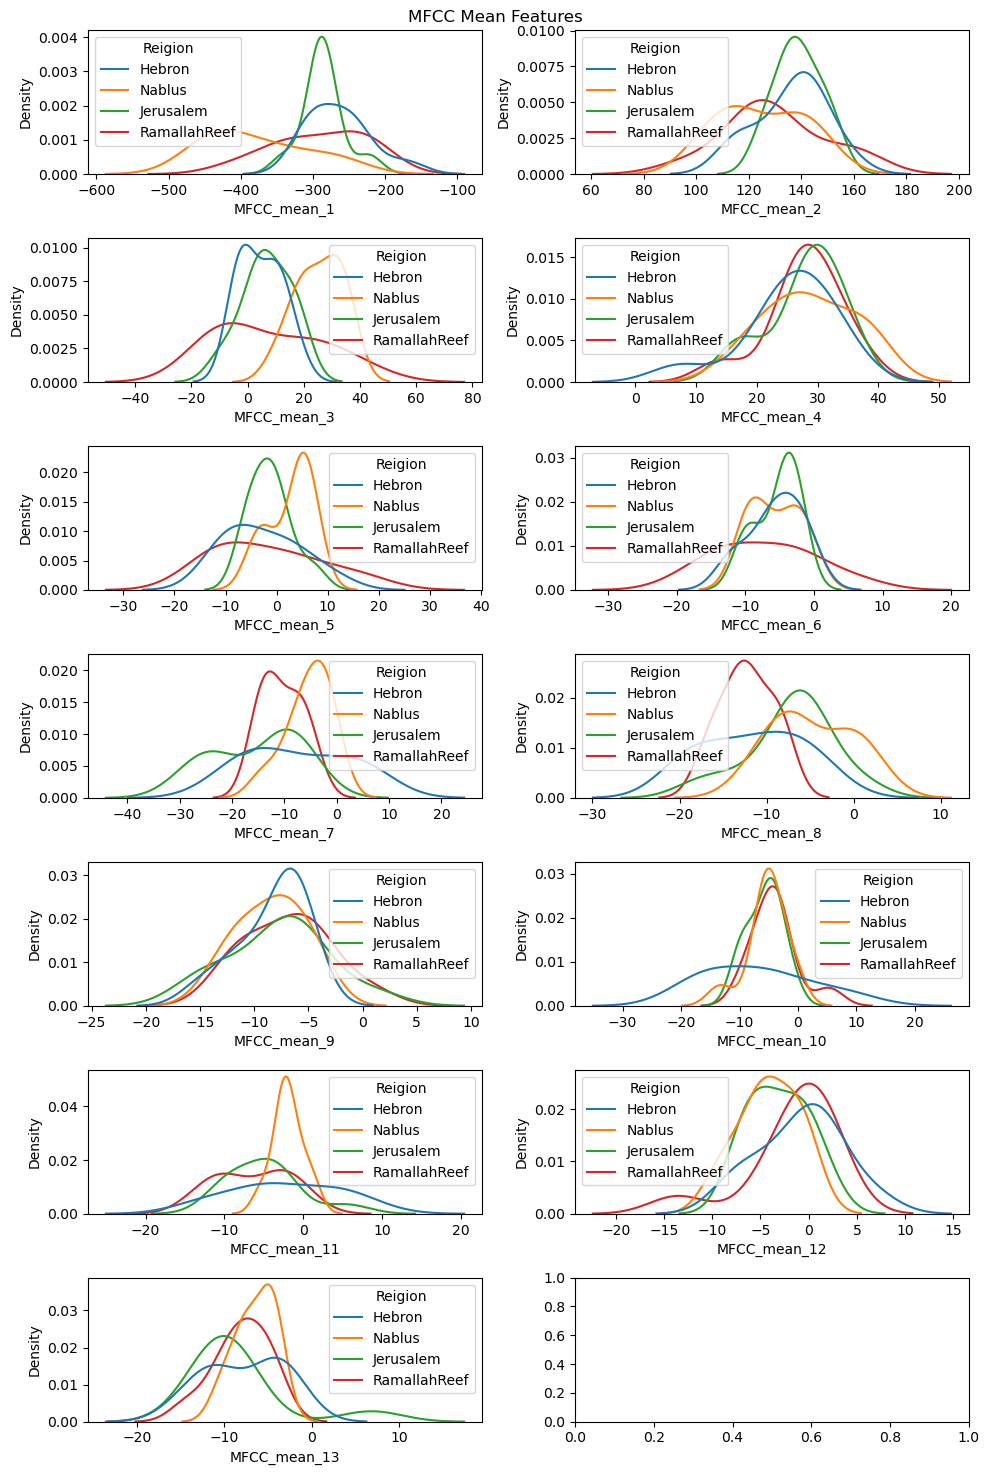

In [28]:
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(10, 15))
fig.suptitle('MFCC Mean Features')

for i, feature in enumerate(training_df.columns[:13], start=1):
    plt.subplot(7, 2, i)
    sns.kdeplot(data=training_df, x=feature, hue="Reigion")
    
plt.tight_layout()
plt.show()

In [13]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
# X_training_scaled = extracted_training_features
# X_testing_scaled = extracted_testing_features

In [14]:
X_train[40]

array([ 1.2466238 ,  0.87263155,  0.2919641 , -0.5618349 , -3.2899606 ,
        0.7916823 ,  2.673316  , -2.8899238 , -0.3645221 , -1.7629555 ,
       -2.279428  ,  1.3853357 , -0.6905013 ], dtype=float32)

# Models

In [24]:
svm_model = SVC(kernel='linear')
svm_model.fit(X_training_scaled, training_labels)

# Example with Random Forest
rfc_model = RandomForestClassifier(n_estimators=100)
rfc_model.fit(X_training_scaled, training_labels)

# Predict on the test set
y_pred_svm = svm_model.predict(X_testing_scaled)
y_pred_random_forest = rfc_model.predict(X_testing_scaled)

# KNN
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_training_scaled, training_labels)
y_pred_knn = knn_model.predict(X_testing_scaled)

# Evaluate the model
print('SVM Report:')
print(classification_report(testing_labels, y_pred_svm))

print('Random Forest Report:')
print(classification_report(testing_labels, y_pred_random_forest))

print('KNN Report:')
print(classification_report(testing_labels, y_pred_knn))


SVM Report:
              precision    recall  f1-score   support

      Hebron       0.67      0.80      0.73         5
   Jerusalem       0.83      1.00      0.91         5
      Nablus       0.67      0.40      0.50         5
RamallahReef       0.80      0.80      0.80         5

    accuracy                           0.75        20
   macro avg       0.74      0.75      0.73        20
weighted avg       0.74      0.75      0.73        20

Random Forest Report:
              precision    recall  f1-score   support

      Hebron       0.40      0.40      0.40         5
   Jerusalem       0.71      1.00      0.83         5
      Nablus       0.50      0.40      0.44         5
RamallahReef       1.00      0.80      0.89         5

    accuracy                           0.65        20
   macro avg       0.65      0.65      0.64        20
weighted avg       0.65      0.65      0.64        20

KNN Report:
              precision    recall  f1-score   support

      Hebron       0.50      

# Hyper-parameter Tuning

In [120]:
svm_param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear']
}
rfc_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# SVM
svm_grid_search = GridSearchCV(SVC(), svm_param_grid, cv=5, n_jobs=-1, verbose=2)
svm_grid_search.fit(X_training_scaled, training_labels)
best_svm_params = svm_grid_search.best_params_

# Random Forest
rfc_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), rfc_param_grid, cv=5, n_jobs=-1, verbose=2)
rfc_grid_search.fit(X_training_scaled, training_labels)
best_rfc_params = rfc_grid_search.best_params_

# KNN
knn_grid_search = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=5, n_jobs=-1, verbose=2)
knn_grid_search.fit(X_training_scaled, training_labels)
best_knn_params = knn_grid_search.best_params_

# SVM
print(f"Best SVM parameters: {best_svm_params}")
print(f"Best Score", svm_grid_search.best_score_)

# RFC
print(f"Best Random Forest parameters: {best_rfc_params}")
print(f"Best Score", rfc_grid_search.best_score_)

# KNN
print(f"Best KNN parameters: {best_knn_params}")
print(f"Best Score", knn_grid_search.best_score_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best SVM parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best Score 0.75
Best Random Forest parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Score 0.7
Best KNN parameters: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
Best Score 0.725


C:\Users\mahmo\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [0.675 0.725 0.625 0.675 0.625 0.65  0.45  0.55  0.45  0.5     nan 0.725
   nan 0.65    nan 0.625   nan 0.55    nan 0.525]
  warnings.warn(


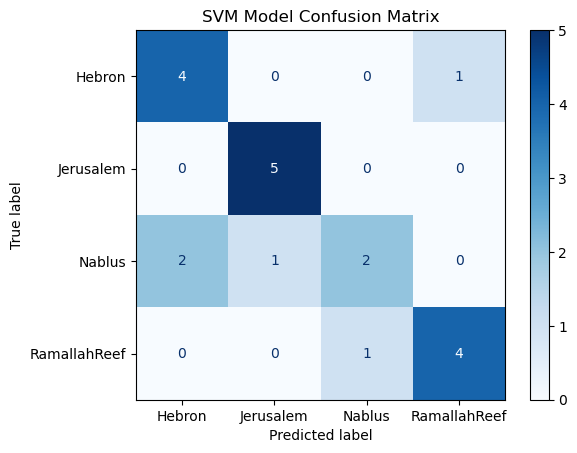

In [48]:
disp = ConfusionMatrixDisplay.from_estimator(
    svm_model,
    X_testing_scaled,
    testing_labels,
    cmap=plt.cm.Blues
#     cmap=plt.cm.GnBu
)
plt.title('SVM Model Confusion Matrix')
plt.show()